In [1]:
!pip install blocksnet==0.0.8 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 672.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.6/355.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import blocksnet as bn
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

from shapely.geometry import Point
from geopandas import GeoDataFrame
from blocksnet.models.land_use import LandUse

In [3]:
!gdown 1XqeXOoFlaWJh_pHyqkPprgUHrP0Pv_m4

Downloading...
From: https://drive.google.com/uc?id=1XqeXOoFlaWJh_pHyqkPprgUHrP0Pv_m4
To: /content/small_model.pickle
100% 48.0M/48.0M [00:00<00:00, 59.5MB/s]


In [4]:
city = bn.City.from_pickle('small_model.pickle')

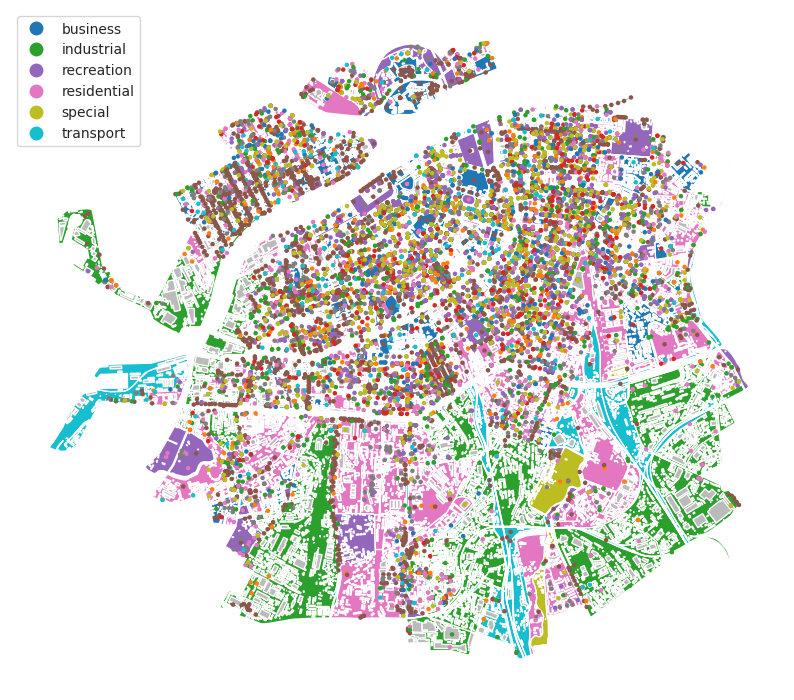

In [5]:
city.plot()

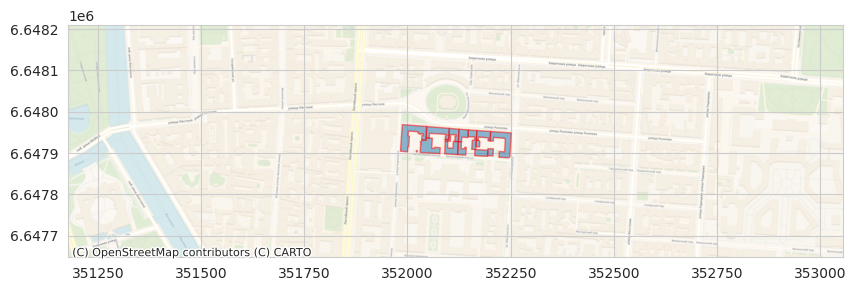

In [8]:
selected_block_id = 824 # Введите номер квартала
selected_block = city[selected_block_id]
ax = selected_block.get_buildings_gdf().plot(figsize=(10, 10), alpha=0.5, edgecolor="r")
ax.margins(3)
df = city.get_blocks_gdf(False)
cx.add_basemap(ax, crs=city.crs, source=cx.providers.CartoDB.Voyager)

In [9]:
orig_landuse = selected_block.land_use # Получим текущий тип землепользования квартала
new_landuse = LandUse.TRANSPORT # Выберем новый тип землепользования

In [10]:
orig_blocks = city.get_blocks_gdf(True) # Получим информацию о кварталах города

In [11]:
# Выбираем область вокруг выбранного квартала
centroid_radius = 1000

centroid = orig_blocks.loc[selected_block_id]['geometry'].centroid #Получим точку квартала на карте

x, y = int(centroid.x), int(centroid.y) #Возьмем координаты квартала

poly_gdf = GeoDataFrame([{"geometry": Point(x, y).buffer(centroid_radius), "value1": x + y, "value2": x - y}])

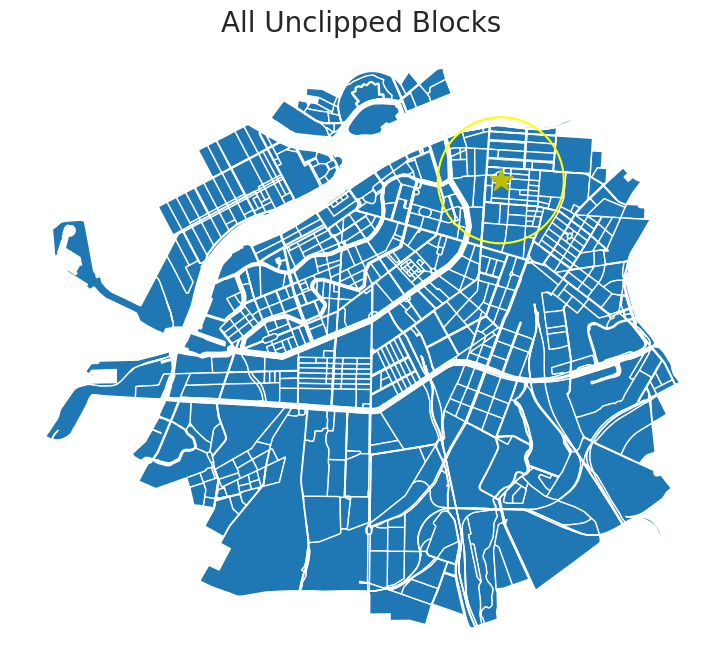

In [14]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
orig_blocks.plot(ax=ax1)
poly_gdf.boundary.plot(ax=ax1, color="yellow")
ax1.set_title("All Unclipped Blocks", fontsize=20)
blocks = orig_blocks.loc[[selected_block_id]]
blocks['centroid'] = blocks.centroid
blocks = blocks.set_geometry("centroid")
blocks.plot(ax=ax1, marker='*', color='y', zorder=2, markersize=300)
ax1.set_axis_off()
plt.show()

In [15]:
#Заменим старую модель на уменьшеную
blocks_clipped = orig_blocks.clip(poly_gdf) # Обрежем кварталы по выбранной области

new_blocks = {}
for idx in blocks_clipped.index:
    new_blocks[idx] = city._blocks[idx]

adj_matrix = city.adjacency_matrix
adj_matrix = adj_matrix[blocks_clipped.index].iloc[blocks_clipped.index]

city._blocks = new_blocks
city.adjacency_matrix = adj_matrix

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:2362: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32636
Right CRS: None

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)


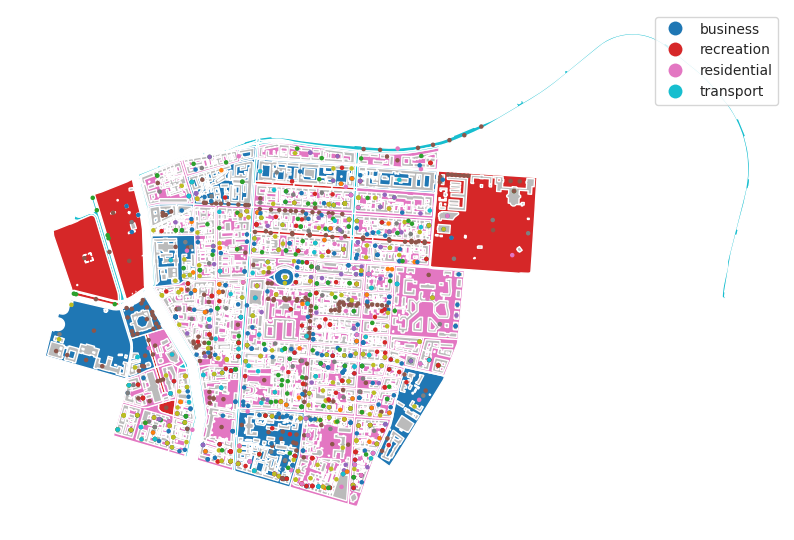

In [16]:
city.plot()

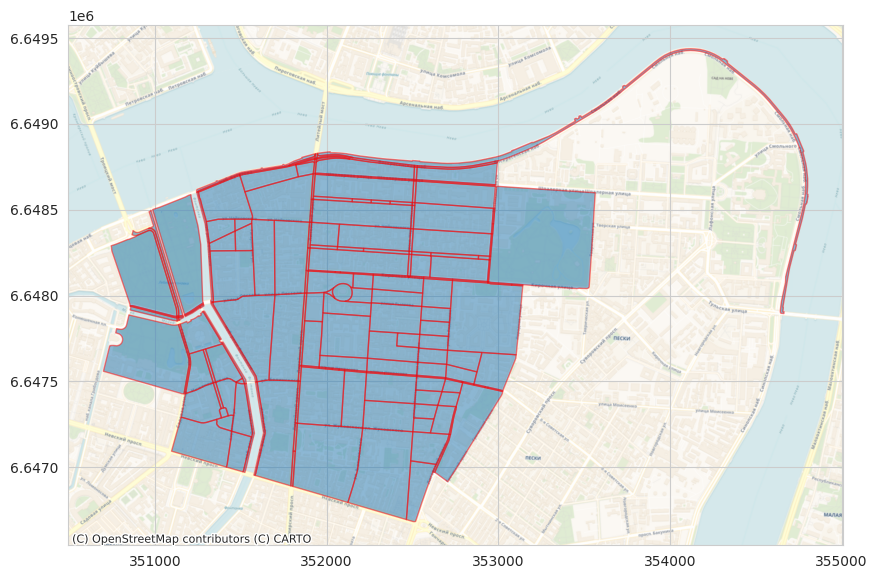

In [17]:
df = city.get_blocks_gdf(False)
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor="r")
cx.add_basemap(ax, crs=city.crs, source=cx.providers.CartoDB.Voyager)

In [18]:
opt = bn.BlockOptimizer(city_model=city) #Инизиализируем класс оптимизатора из библиотеки BlocksNet
result, deleting_update_df = opt.calculate(selected_block=selected_block, new_landuse=new_landuse) # Укажем парметры для которых будут происходить рассчеты

In [19]:
result['optimal_update_df'] # Из результата методы получим информацию об оптимальных сервисах

,bus_stop,landfill
824,102,112000


In [20]:
deleting_update_df # Выведем информацию о сервисах, которые были снесены при смене землеползования

,hairdresser,park,hotel,restaurant,cafe,bakery,population
824,-85,-5,-829,-3,-968,-95,-626


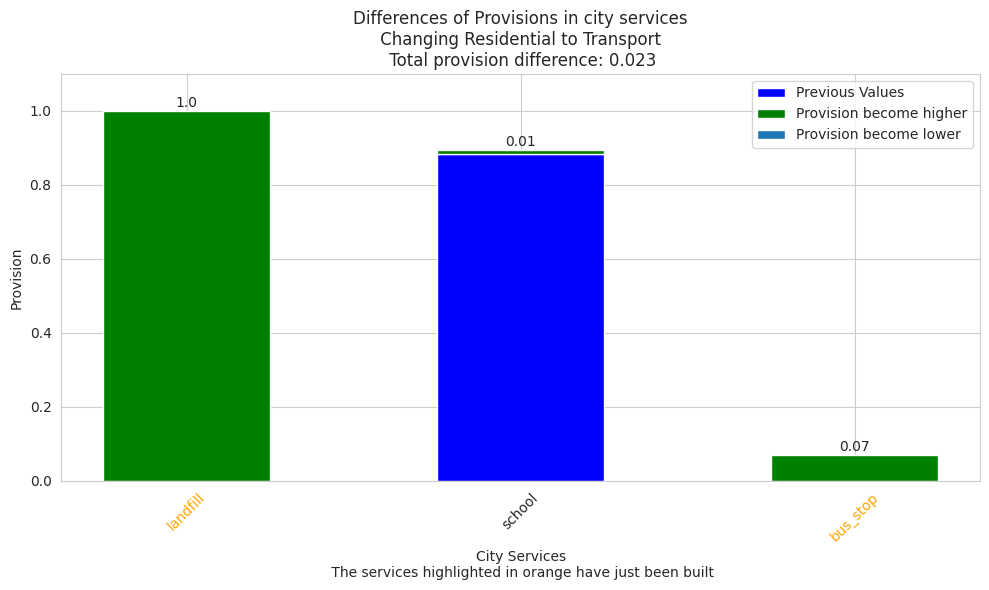

In [21]:
opt.plot(**result)

In [22]:
from blocksnet.method.provision.provision import Provision, ProvisionMethod

prov = Provision(city_model=city) # Инизиализируем класс для рассчета обеспеченность из библиотеки BlocksNet
service_type = city['school'] # Выберем тип сервиса для рассчетов

In [23]:
calc_before = prov.calculate(service_type, method=ProvisionMethod.GRAVITATIONAL, self_supply=True) # Рассчитаем обеспеченность до изменений

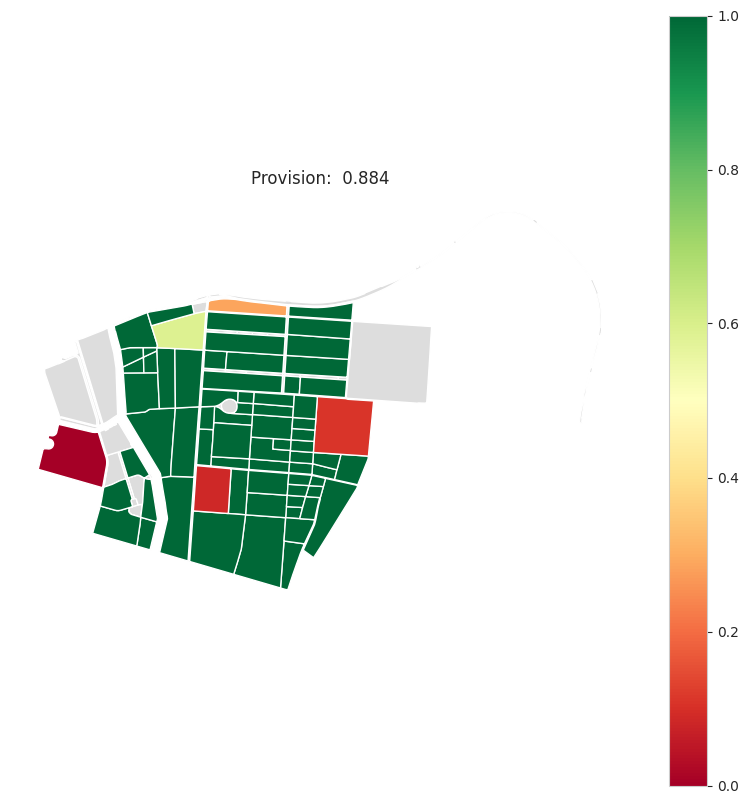

In [24]:
prov.plot(calc_before)

In [25]:
optimal_update_df = result['optimal_update_df']
update_df = optimal_update_df.combine_first(deleting_update_df) #Объединим удаленные и построенные сервисы для рассчета обеспеченности

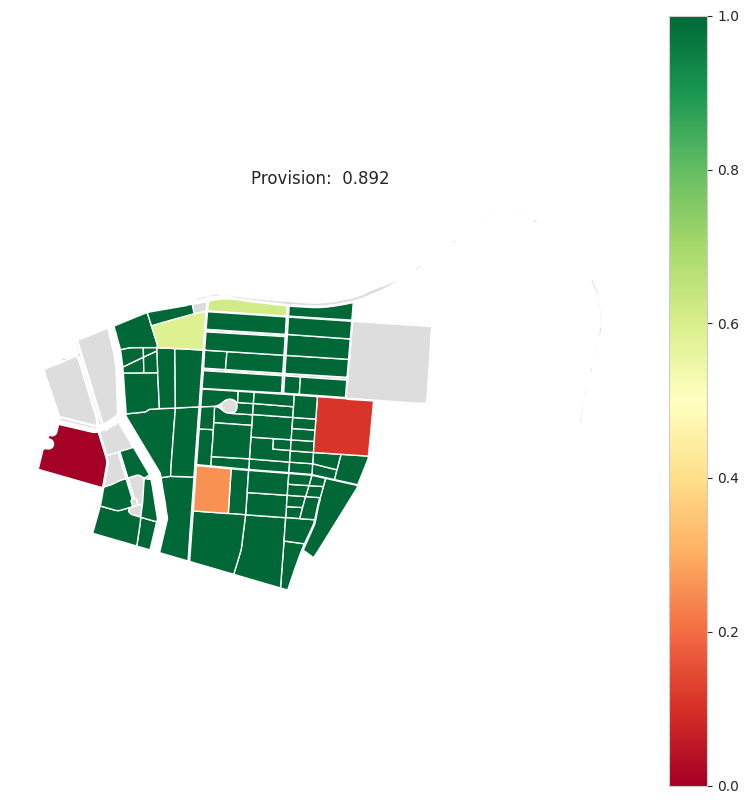

In [26]:
calc_after = prov.calculate(service_type, update_df=update_df, method=ProvisionMethod.GRAVITATIONAL, self_supply=True) # Рассчитаем обеспеченность после изменений
prov.plot(calc_after)

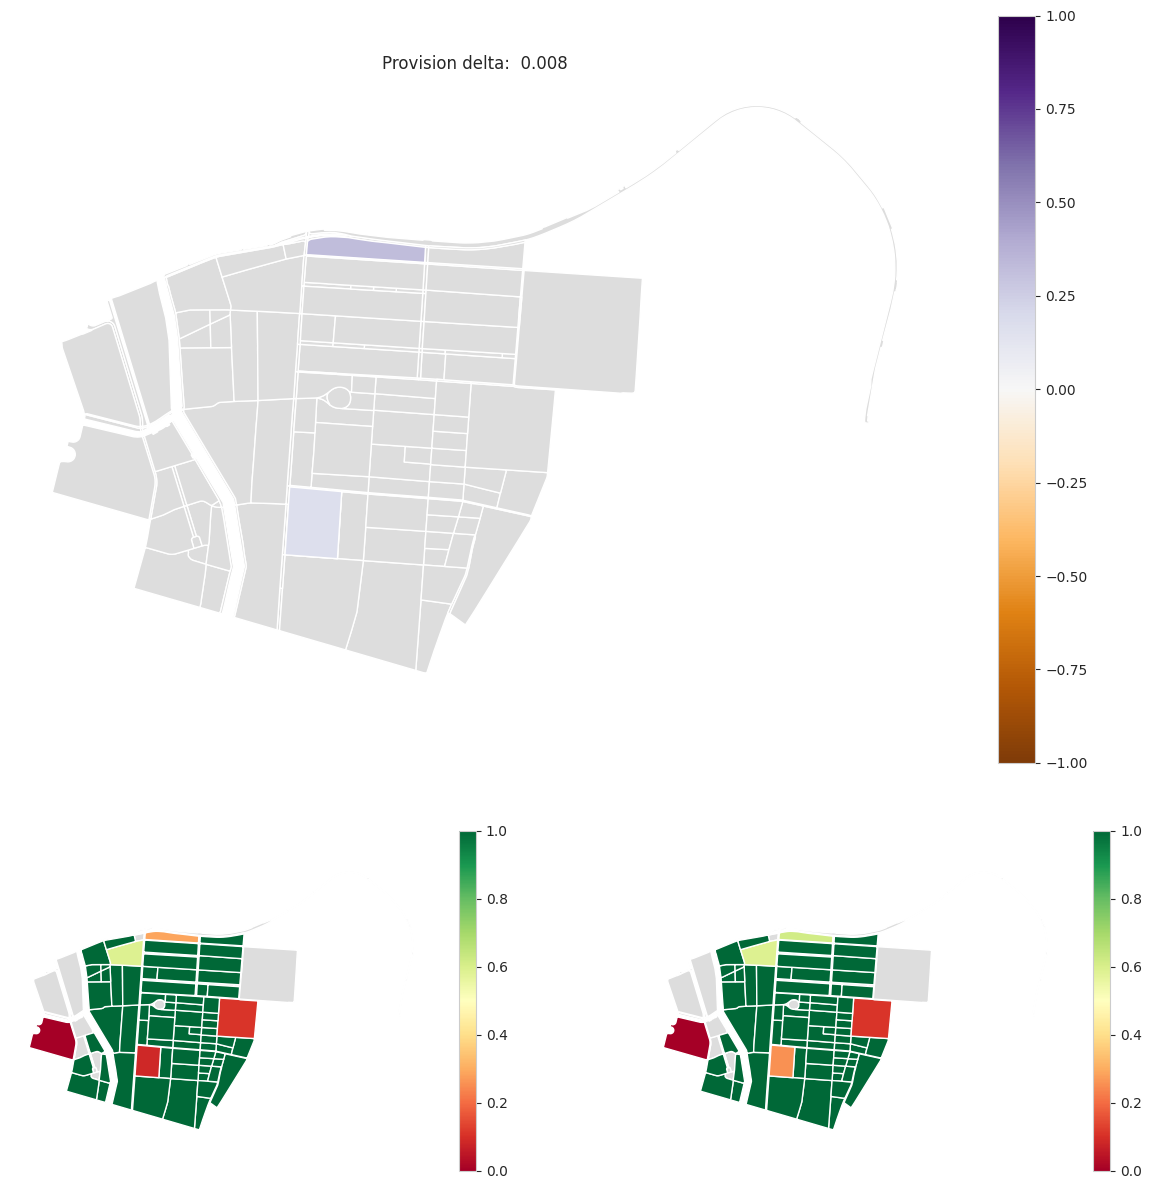

In [27]:
prov.plot_delta(calc_before, calc_after, figsize=(15,15))

In [28]:
best_landuse = selected_block.land_use
temp_diff = 0

for lanuse in LandUse:
    result, deleted_df = opt.calculate(selected_block=selected_block, new_landuse=lanuse)
    diff = result['total_after'] - result['total_before'] # Найдем разницу между общим изменением обеспеспеченности до и после

    print(f'{selected_block.land_use} -> {lanuse}: {round(diff, 3)}')

    # Если обеспеченность у текущего землепользования лучше, чем текущая максимальная, заменим максимальную на текущую
    if diff > temp_diff:
        temp_diff = diff
        best_landuse = lanuse

print(f'best lanuse {best_landuse}')

LandUse.RESIDENTIAL -> LandUse.RESIDENTIAL: 0.001
LandUse.RESIDENTIAL -> LandUse.BUSINESS: 0.001
LandUse.RESIDENTIAL -> LandUse.RECREATION: 0.002
LandUse.RESIDENTIAL -> LandUse.SPECIAL: 0.023
LandUse.RESIDENTIAL -> LandUse.INDUSTRIAL: 0.0
LandUse.RESIDENTIAL -> LandUse.AGRICULTURE: 0.002
LandUse.RESIDENTIAL -> LandUse.TRANSPORT: 0.023
best lanuse LandUse.SPECIAL
